In [180]:
''' Import packages. '''
# Time packages
import cftime, datetime, time
# Numerical analysis packages
import numpy as np, random, scipy
# Local data storage packages
import dill, os, pickle
# Data structure packages
import pandas as pd, xarray as xr
# Visualization tools
import matplotlib.pyplot as plt

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [254]:
def tc_storage(model, experiment, year_range, storm_type, random_num=None, benchmarking=True):
    
    ''' 
    Function to build unified xArray Dataset to hold model and track data for tracked TCs in a given model and experiment.
    
    Input(s):
    - model (str):                name of model to access (typically "AM2.5" or "HIRAM")
    - experiment (str):           name of experiment to access (typically "control", "ktc", "plus2K", etc.)
    - year_range (tuple of ints): 2-element tuple with a start and end year
    - storm_type (str):           type of storm to evaluate from TC tracks data ("TS" for all storms or "C15w" for hurricanes)
    - benchmarking (bool):        boolean to enable time benchmarking
    Output(s):
    - dirs (tuple):               2-element tuple with pathnames for the model- and experiment-specific GCM and track directories.
    '''
    
    if benchmarking:
        start = time.time()
    
    # Define paths to model- and experiment-specific data.
    model_dir, track_dir = dirnames(model, experiment)
    # Retrieve tracked TCs over the specified year range. Note: year_range re-specified to ensure increasing order in tuple.
    storm_track_output = retrieve_tracked_TCs(track_dir, storm_type, year_range=(min(year_range), max(year_range)))
    # Retrieve model data over specified year range. 
    # This is here so that both TC-specific and associated global model data can be analyzed together.
    model_output = retrieve_model_data(model_dir, year_range=(min(year_range), max(year_range)), output_type='atmos_daily')
    # Retrieve model data specified to tracked TCs.
    # Note: default model output type is 'atmos_4xdaily'. If 'output_type' matches 'model_output', then access pre-loaded data from 'model_output'.
    storm_model_output = retrieve_model_TCs(model_dir, (min(year_range), max(year_range)), storm_track_output, 
                                            model_output, output_type='atmos_4xdaily', random_num=random_num)
    
    if benchmarking:
        print('Runtime: {0:.3f} s'.format(time.time() - start))
    
    return storm_model_output

In [182]:
def dirnames(model, experiment):

    ''' 
    Function to store pathnames for selected models and experiments. 
    
    Input(s):
    - model (str):  name of model to access (typically "AM2.5" or "HIRAM").
    Output(s):
    - dirs (tuple): 2-element tuple with pathnames for the model- and experiment-specific GCM and track directories.
    '''
    
    # Define experiment-specific pathnames
    experiments = {'control': {'AM2.5': 'CTL1990s_tigercpu_intelmpi_18_540PE',
                               'HIRAM': 'CTL1990s_v201910_tigercpu_intelmpi_18_540PE'},
                   'ktc': {'AM2.5': 'CTL1990s_killtc13-13-15_tigercpu_intelmpi_18_540PE',
                           'HIRAM': 'CTL1990s_v201910_killtc13-13-15_tigercpu_intelmpi_18_540PE'}}
    # Model directories
    model_dirs = {'AM2.5': {'control': '/tigress/wenchang/analysis/TC/AM2.5/CTL1990s_tigercpu_intelmpi_18_540PE/model_out/POSTP',
                            'ktc': '/tigress/wenchang/analysis/TC/AM2.5ktc2/CTL1990s_killtc13-13-15_tigercpu_intelmpi_18_540PE/modelout/POSTP'},
                  'HIRAM': {'control': '/tigress/wenchang/analysis/TC/HIRAM/CTL1990s_v201910_tigercpu_intelmpi_18_540PE/model_out/POSTP',
                            'ktc': '/tigress/wenchang/analysis/TC/HIRAMktc2/CTL1990s_v201910_killtc13-13-15_tigercpu_intelmpi_18_540PE/modelout/POSTP'}}
    # Track directories
    # Potential issue: ask Wenchang about using track .nc files in the same parent directory tree as the model data
    track_dirs = {'AM2.5': {'control': '/tigress/wenchang/MODEL_OUT/AM2.5/CTL1990s_tigercpu_intelmpi_18_540PE/analysis_lmh/cyclones_gav_ro110_1C_330k',
                            'ktc': '/tigress/wenchang/MODEL_OUT/AM2.5ktc2/CTL1990s_killtc13-13-15_tigercpu_intelmpi_18_540PE/analysis_lmh/cyclones_gav_ro110_1C_330k'},
                  'HIRAM': {'control': '/tigress/wenchang/MODEL_OUT/HIRAM/CTL1990s_v201910_tigercpu_intelmpi_18_540PE/analysis_lmh/cyclones_gav_ro110_2p5C_330k',
                            'ktc': '/tigress/wenchang/MODEL_OUT/HIRAMktc2/CTL1990s_v201910_killtc13-13-15_tigercpu_intelmpi_18_540PE/analysis_lmh/cyclones_gav_ro110_1C_330k'}}

    dirs = (model_dirs[model][experiment], track_dirs[model][experiment])
    
    return dirs

In [183]:
def lmh_parser(path):
    
    ''' 
    This method parses through text files from Lucas Harris' run outputs (held in directories titled 'analysis_lmh') 
    and produces an output DataFrame. 
    
    Input(s):
    - path (str):            path containing raw tracker data from Lucas Harris' runs.
    Output(s):
    - df (Pandas DataFrame): Pandas DataFrame containing tracked TC data
    '''
    
    # Create file object instance
    fobj = open(path, 'r').readlines()
    # Initialize dictionary to hold data
    data = {'storm_num': {}}
    # Initialize storm counter
    count = 1
    # Iterate through text file
    for line in fobj:
        # Extract information from the line
        content = line.strip()
        # Creates new storm-specific dict in the parent dict. The '+++' demarcates a new storm.
        if '+++' in line:
            storm_num = '{0:04d}'.format(count)
            data['storm_num'][storm_num] = {'storm_id': [], 'time': [], 'lon': [], 'lat': [], 'slp': [], 'max_wnd': [], 'flag': []}
            count += 1
        # Populates the storm-specific dict
        else:
            storm_num = '{0:04d}'.format(count-1) 
            tc_info = [x for x in content.split(' ') if x]
            year = tc_info[0][0:4] # get 4-digit year
            data['storm_num'][storm_num]['storm_id'].append('{0}-{1:04d}'.format(year, count-1))
            data['storm_num'][storm_num]['time'].append(tc_info[0])
            data['storm_num'][storm_num]['lon'].append(tc_info[1])
            data['storm_num'][storm_num]['lat'].append(tc_info[2])
            data['storm_num'][storm_num]['slp'].append(tc_info[3])
            data['storm_num'][storm_num]['max_wnd'].append(tc_info[4])
            data['storm_num'][storm_num]['flag'].append(tc_info[5])
    
    try:
        # Converts the dictionary into a DataFrame
        df = pd.concat({k: pd.DataFrame(v).T for k, v in data.items()}, axis=1)['storm_num']
        df = df.explode(df.columns.to_list()).reset_index().rename(columns={'index': 'storm_num'})
        # Re-cast column data types
        df = df.astype({'lon': 'float', 'lat': 'float', 'slp': 'float', 'max_wnd': 'float', 'flag': 'float'})
    except:
        df = pd.DataFrame(columns=['storm_id', 'time', 'lon', 'lat', 'slp', 'max_wnd', 'flag'])
    
    ''' DataFrame refinement. '''
    # Remove cold-core data points (flag == -1)
    df = df.loc[df['flag'] != -1].reset_index(drop=True)
    # Convert timestamps to datetime objects
    df['time'] = pd.to_datetime(df['time'], format='%Y%m%d%H')
    
    return df

In [184]:
def coords_to_dist(a, b):
    ''' Convert coordinates to distance in meters. '''
    
    R = 6371e3
    
    lon_a, lat_a = np.array(a)*np.pi/180
    lon_b, lat_b = np.array(b)*np.pi/180
    
    dlon, dlat = lon_b - lon_a, lat_b - lat_a
    
    a = np.sin(dlat/2)**2 + np.cos(lat_a)*np.cos(lat_b)*np.sin(dlon/2)**2    
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    distance = R*c
    
    return distance

In [213]:
def retrieve_tracked_TCs(dirname, storm_type, year_range):

    '''
    Function to collect tracked TC data and add derived data, such as duration and storm speed.
    
    Input(s):
    - dirname (str):              name of directory containing files of interest
    - storm_type (str):           type of storm to evaluate from TC tracks data ("TS" for all storms or "C15w" for hurricanes)
    - year_range (tuple of ints): 2-element tuple with a start and end year
    Output(s):
    - data (Pandas DataFrame):    Pandas DataFrame with tracked TC data
    '''
    
    ''' File collection. '''
    # Get filenames for all files within the specified directory 
    # Filenames will correspond to the determined storm type
    fnames = [[os.path.join(dirname, file, 'Harris.TC', f) for f in os.listdir(os.path.join(dirname, file, 'Harris.TC')) 
               if '{0}.world'.format(storm_type) in f]
               for file in sorted(os.listdir(dirname))]
    # Compress 2D list to 1D list
    fnames = [item for sublist in fnames for item in sublist]

    # Select files with dates within 'year_range'
    # Note: the '+ 1900' is added because tracked TCs are on the 2000 year range, whereas model output is on the 100 year range
    fnames = [f for f in fnames 
              if min(year_range) + 1900 <= pd.to_datetime(f.split('.')[-2].split('-')[0]).year < max(year_range) + 1900]
    
    # Concatenate all tracked TC data from the filename list
    data = pd.concat([lmh_parser(os.path.join(dirname, fname)) for fname in fnames])
    
    ''' Derived track-based data algorithm. Storm-specific derived properties will be generated in here. '''
    
    # Initialize empty duration column to populate iteratively
    data[['duration', 'speed', 'direction']] = np.nan
    # Initialize list to populate iteratively for each storm, then concatenate
    storms = []
    # Iterate through each unique storm (identify by 'storm_id') and get duration
    for storm_id in data['storm_id'].unique():
        # Define iterand storm
        storm = data.loc[data['storm_id'] == storm_id].copy().reset_index(drop=True)
        
        ''' Duration derivation. '''
        # Get difference between minimum and maximum timestamps
        dt = (storm['time'].max() - storm['time'].min())
        # Convert difference timedelta into hours
        dt = dt.days + dt.seconds/86400
        # Add duration to the outer DataFrame for the corresponding storm
        data.loc[data['storm_id'] == storm_id, 'duration'] = dt
        # Re-define iterand storm to incorporate duration
        storm = data.loc[data['storm_id'] == storm_id].copy().reset_index(drop=True)
        
        ''' Velocity (speed, direction) derivation. '''
        # Initialize dictionary for preliminary storage. Will be reassigned into the DataFrame by the join() method using time as the matching criterion.
        velocity = {'time': [storm.iloc[0]['time']], 'speed': [np.nan], 'direction': [np.nan]}
        # Iterate over all of the iterand storm timestamps
        for i in range(1, len(storm)):
            # Define coordinates for two points considered (i, i-1)
            lon_a, lat_a = [storm.iloc[i-1]['lon'], storm.iloc[i-1]['lat']]
            lon_b, lat_b = [storm.iloc[i]['lon'], storm.iloc[i]['lat']]
            # Determine timedelta between points (i, i-1)
            dt = storm.iloc[i]['time'] - storm.iloc[i-1]['time']
            # Derive speed (distance / time in m s^-1)
            speed = coords_to_dist((lon_b, lat_b), (lon_a, lat_a))/dt.seconds
            # Get changes in longtiude and latitude
            dlon, dlat = lon_b - lon_a, lat_b - lat_a
            # Derive direction relative to north (range of 0 to 360)
            direction = 180*np.arctan(dlon/dlat)/np.pi % 360
            # Append quantities to the 'velocity' dictionary
            velocity['time'].append(storm.iloc[i]['time'])    
            velocity['speed'].append(speed)    
            velocity['direction'].append(direction)
        # Build DataFrame
        velocity = pd.DataFrame(velocity)
        # Re-cast time column as a datetime object
        velocity['time'] = pd.to_datetime(velocity['time'])
        # Merge the storm and velocity DataFrames
        storm = storm.merge(velocity, how='left', on='time', suffixes=['_x', None]).drop(columns={'speed_x', 'direction_x'}).reset_index(drop=True)
        # Append to the list for future concatenation
        storms.append(storm)
        
    # Concatenate DataFrames
    data = pd.concat(storms)   
    # Rename columns for future addition into xArray Dataset, and reset index
    data = data.rename(columns={'lon': 'center_lon', 'lat': 'center_lat', 'flag': 'core_temp', 'slp': 'min_slp'}).reset_index(drop=True)
        
    return data

In [186]:
def pull_gcm_data(dirname, year, output_type):
    
    ''' Method to read data for given parameters. '''
    
    # Get filenames for corresponding files
    filename = '{0:04d}0101.{1}.nc'.format(year, output_type)
    try:
        fname = os.path.join(dirname, filename)
        # Retrieve data
        data = xr.open_dataset(fname)
    except:
        return None
    
    return data

In [187]:
def retrieve_model_data(dirname, year_range, output_type='atmos_daily'):
    
    '''
    Method to open experiment-specific GCM output data for a specified year range and model output type.
    
    Input(s):
    - dirname (str):            directory name for the given model and experiment type.
    - year_range (tuple, list): tuple or list (minimum of 2 items) containing year range for desired data.
    - output_type (str):        string denoting GCM output desired.
    Output(s):
    - data (xArray Dataset):    xArray Dataset containing concatenated data for the year range selected.
    '''
    
    # Identifier substring definition. This will be used for splitting the filename for identification purposes.
    substring = '0101.'
    # Access parent directory with experiment-specific model data and list directories corresponding to year range
    files = [os.path.join(dirname, file) for file in os.listdir(dirname) for year in range(min(year_range), max(year_range)) 
             if str(year) in file.split(substring)[0] and output_type in file]
    # Store file data into an xArray Dataset.
    # Note: benchmarking showed ~1.5 s for opening 4 files using 'open_mfdataset', and at least 10x longer using 'open_dataset' + 'xr.concat'
    data = xr.open_mfdataset(files)
    
    return data

In [252]:
def retrieve_model_TCs(dirname, year_range, storms, model_output=None, output_type='atmos_4xdaily', extent=15, random_num=None):
    
    # Check to see if model_output (previously-access model data) is the same output type as desired for TCs. If so, pull from that Dataset.
    if model_output and output_type == model_output.attrs['filename'].split('.')[0]:
        data = model_output
    else:
        # Identifier substring definition. This will be used for splitting the filename for identification purposes.
        substring = '0101.'
        # Access parent directory with experiment-specific model data and list directories corresponding to year range
        files = [os.path.join(dirname, file) for file in os.listdir(dirname) for year in range(min(year_range), max(year_range)) 
                 if str(year) in file.split(substring)[0] and output_type in file]
        # Store file data into an xArray Dataset.
        data = xr.open_mfdataset(files)
    
    # Initialize list to hold each storm Dataset for future concatenation
    storms_xr = []
    # Define range of storm IDs to iterate over. 
    # If 'random_num' is defined, get that many randomized storms. Otherwise, get all.
    storm_ids = random.sample(list(storms['storm_id'].unique()), random_num) if random_num else storms['storm_id'].unique()
    # Access model data that are specific to each tracked TC.
    for storm_id in storm_ids:
        # Pull tracked TC data relative to storm
        storm = storms.loc[storms['storm_id'] == storm_id]
        # Initialize list to hold Dataset entries for each storm timestamp
        storm_xr = []
        # Iterate over each storm Series
        for i in range(0, len(storm)):                   
            # Convert from tracked TC timestamp convention (datetime) to model timestamp convention (cftime DatetimeNoLeap)
            cf_timestamp = cftime.DatetimeNoLeap(year=storm.iloc[i]['time'].year-1900, month=storm.iloc[i]['time'].month, 
                                                 day=storm.iloc[i]['time'].day, hour=storm.iloc[i]['time'].hour)
            # Take snapshot of data at this timestamp
            # Note 1: this is where the connection between track and model output data happens
            # Note 2: any operations beyond selection result in active computation, which disrupts the 'lazy' approach
            snapshot = data.sel(time=cf_timestamp)
            # Get iterand information to append to Dataset for the given timestamp
            snapshot[['center_lon', 'center_lat', 'min_slp', 'max_wnd', 'core_temp', 'speed']] = [storm.iloc[i]['center_lon'], storm.iloc[i]['center_lat'], storm.iloc[i]['min_slp'],
                                                                                                  storm.iloc[i]['max_wnd'], storm.iloc[i]['core_temp'],
                                                                                                  storm.iloc[i]['speed']]  
            # Append to list
            storm_xr.append(snapshot)
        # Concatenate into unified Dataset for a storm
        storm_xr = xr.concat(storm_xr, dim='time')
        # Assign storm identifier (storm_id)
        # Note: to select specific storm from concatenated Dataset, use command as follows:
        #       storms.where(storms['storm_id'] == <storm_id>, drop=True)
        storm_xr['storm_id'] = storm_id
    
        ''' Spatial clipping - only at maximum intensity to save computation time. '''
        # Grab storm at timestamp with maximum wind speed
        # Calling this 'lifetime maximum intensity', or 'LMI', to use terminology from Wing et al, 2016 (10.1175/JCLI-D-18-0599.1)
        lmi = storm_xr.where(storm_xr['max_wnd'] == storm_xr['max_wnd'].max(), drop=True)
        # Clip storm        
        lmi = lmi.sel(grid_xt=np.arange(lmi['center_lon']-extent, lmi['center_lon']+extent), 
                      grid_yt=np.arange(lmi['center_lat']-extent, lmi['center_lat']+extent), method='nearest')
        
        # Append to list for future concatenation
        storms_xr.append(lmi)
        
    # Concatenate into single xArray Dataset
    storms_xr = xr.concat(storms_xr, dim='time')
    
    return storms_xr

In [257]:
model = 'AM2.5'
experiment = 'control'
storm_type = 'C15w'
year_range = (101, 105)
storms = tc_storage(model, experiment, year_range, storm_type, random_num=20, benchmarking=True)

del model, experiment, storm_type, year_range

Runtime: 11.477 s


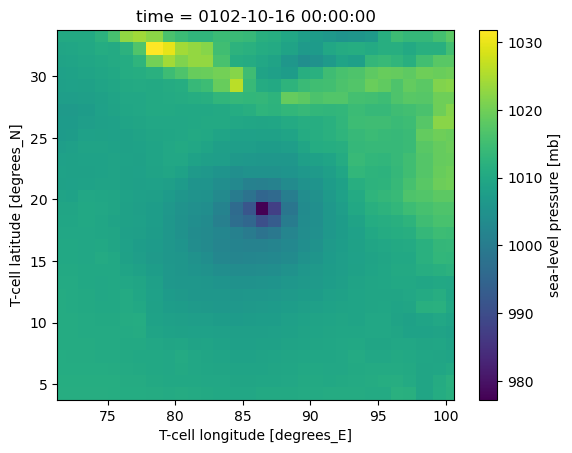

In [258]:
storm_ids = list(set(storms['storm_id'].values))
test_storm = storms.where(storms['storm_id'] == random.sample(storm_ids, 1), drop=True).dropna(dim='grid_xt', how='all').dropna(dim='grid_yt', how='all')
test_storm['slp'].plot()
del test_storm

In [259]:
storms

<xarray.Dataset>
Dimensions:       (grid_xt: 268, grid_yt: 157, time: 20, bnds: 2)
Coordinates:
  * grid_xt       (grid_xt) float64 37.81 39.06 39.69 ... 275.9 277.2 277.8
  * grid_yt       (grid_yt) float64 -47.75 -46.75 -45.75 ... 38.25 38.75 39.25
  * time          (time) object 0103-12-20 00:00:00 ... 0104-06-18 18:00:00
Dimensions without coordinates: bnds
Data variables: (12/19)
    WVP           (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 157, 268), meta=np.ndarray>
    grid_xt_bnds  (time, grid_xt, bnds) float64 dask.array<chunksize=(1, 268, 2), meta=np.ndarray>
    grid_yt_bnds  (time, grid_yt, bnds) float64 dask.array<chunksize=(1, 157, 2), meta=np.ndarray>
    h300          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 157, 268), meta=np.ndarray>
    h500          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 157, 268), meta=np.ndarray>
    h850          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 157, 268), meta=np.ndarray>
    ...            ...
    center_lat    (time) float64 -16.35 4.27 4.3 -13.84 ... 23.3 20.85 22.95
    min_slp       (time) float64 963.0 984.6 987.0 984.4 ... 978.2 988.6 970.3
    max_wnd       (time) float64 34.88 34.15 32.23 30.19 ... 31.33 34.22 30.88
    core_temp     (time) float64 264.1 261.3 261.5 262.5 ... 264.4 263.6 266.4
    speed         (time) float64 2.52 3.655 4.095 2.41 ... 2.627 2.893 1.368
    storm_id      (time) object '2003-0023' '2003-0004' ... '2004-0012'
Attributes:
    filename:      atmos_4xdaily.tile1.nc
    title:         CM2.5_A_Control-1990_FLOR_B01
    grid_type:     regular
    grid_tile:     N/A
    history:       Fri Aug 14 11:56:18 2020: ncks -7 -L 1 POSTP/01010101.atmo...
    code_version:  $Name: tikal_201409 $
    NCO:           netCDF Operators version 4.9.2 (Homepage = http://nco.sf.n...

(array([1., 1., 0., ..., 1., 0., 1.]),
 array([920.51  , 923.3108, 926.1116, ..., 984.9284, 987.7292, 990.53  ]),
 <BarContainer object of 25 artists>)

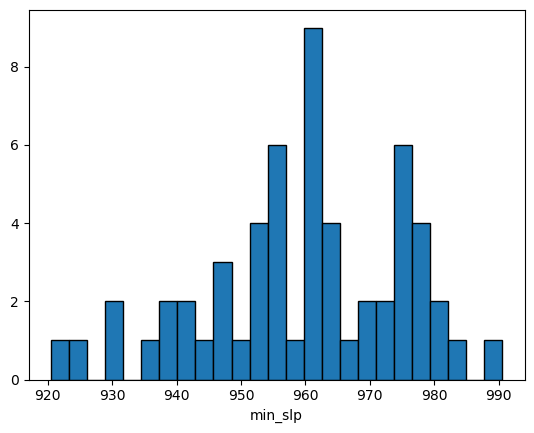

In [230]:
storms['min_slp'].plot.hist(ec='k', bins=25)